In [1]:
#1 Importing the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import joblib

In [2]:
#2 Save the root directory
base_path = Path.cwd().resolve()
print(base_path)

C:\Users\Matth\OneDrive\Desktop\Single_Layer_NN_V1


In [3]:
#3 import the SCRAM codes
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}\\{data_dir}\\SCRAM\\Code')
from import_scram import SCRAM
from simulate_scram import SCRAMTarget
os.chdir(base_path)

In [15]:
#4 Plotter2 plots one spectra from an array of points, and simulates one using SCRAM
def plotter2(dens, temp, flor, err,dx=0.5e-4, exp_specVH = [],exp_specHR=[],  err2=0, dx2 = 0.5e-4, ploton=False, compare = False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence
    scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
    j,k,j_f,k_f,fh,fj = scram.get_scram_intrp(dx) #Extracts j, k from SCRAM


    if ploton == True:
        fig, axs = plt.subplots(nrows = 1, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(4)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs.plot(en_VH,exp_specVH, label = 'Saved')
        axs.set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs.set(xlabel = 'Photon Energy [keV]')
        

        
        if compare == True:
            target1 = SCRAMTarget(dens,temp,j,k,j_f,k_f,fh,fj,en_VH,en_HR,dx)
    
            #generating test spectra with noise
            #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
            test_VH, test_HR = target1.model(dens,temp,flor,100)

            error = err #controls how noisy the spectra are
            error2 = err2
            noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
            
            
            
            axs.plot(en_VH,test_VH+noise_VH, linestyle = '--',label = 'Generated using parameters')
            axs.set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs.set(xlabel = 'Photon Energy [keV]')
            axs.legend()
        

        colors = np.random.rand(3,3)
        axs.axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs.axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs.axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs.axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs.axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs.axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs.legend()


    
    return noise_VH

In [13]:
#5 Write the dataset


num_files = 65 # Number of files to generate
num_trials = 1000 #Number of spectra per file



dx = 0.5e-4  # Single layer of thickness 500 nm

# Initialize SCRAM and get interpolators
scram = SCRAM(f'{data_dir}/SCRAM/SCRAM.txt')
en_VH = np.linspace(8, 9.97, 2995)
en_HR = np.linspace(8, 9.97, 2995)  # Spectral range of front side von Hamos spectrometer
j, k, j_f, k_f, fh, fj = scram.get_scram_intrp(dx)

# Pre-generate random values for density, temperature, and fluorescence

# Prepare arrays to store results



# Loop through each trial
for n in range(num_files):
    intensities = []
    variables = []
    for i in range(num_trials):
        
        dens = np.random.uniform(2.23,10.764) #Density Range
        temp = np.random.uniform(1,6.4) #Temperature Range
        flor = 1e-3 #Florescence (held constant for high temperature spectra (value shouldn't matter))
        noise_val = np.random.uniform(0,0.3) #Noise Range
        
        
        target = SCRAMTarget([dens], [temp], j, k, j_f, k_f, fh, fj, en_VH, en_HR, dx)
        # Create SCRAM target
        # Generate test spectra
        test_VH, _ = target.model([dens], [temp], flor, 100)
        # Add noise to the spectra
        noise_VH = np.random.normal(0, noise_val * np.std(test_VH), en_VH.shape)
        # Combine the spectra and store in arrays
        intensities.append(test_VH + noise_VH)
        variables.append([dens, temp])
        

    # Convert to DataFrame
    energy_intensity_df = pd.DataFrame(intensities)
    dens_temp_noise_df = pd.DataFrame(variables)

    # Save DataFrames
    joblib.dump(energy_intensity_df, f'{base_path}\\rawhigh\\EID_{n}.pkl')
    joblib.dump(dens_temp_noise_df, f'{base_path}\\rawhigh\\DTF_{n}.pkl')
    print(n)


5e-05
0
1
2
3
4
5
6
7
8
9


5e-05


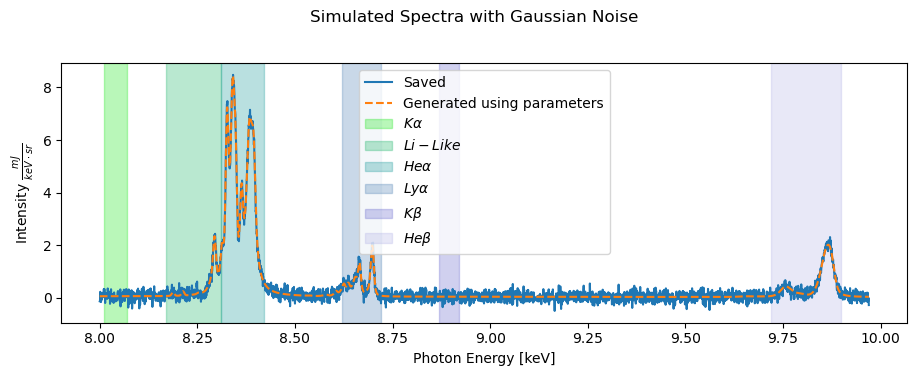

In [16]:
#6 Plot the final saved spectra against a spectra generated from the final saved density, temperature, and fluorescence values
x = plotter2(dens,temp,1e-3,0, exp_specVH = energy_intensity_df.iloc[-1,:], exp_specHR=energy_intensity_df.iloc[-1,:],ploton=True,compare=True )